In [1]:
import numpy as np 
import glob
import cv2
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import PIL.Image as Image 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import models,transforms 
import torchvision.models as models
import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
import os
import pandas as pd

data_dir = '/kaggle/input/modified-hyperkvasir/HyperKvasir'

filepaths = []
labels = []

# Iterate through the directories and collect file paths and labels
for root, dirs, files in os.walk(data_dir):
    for f in files:
        
        class_name = os.path.basename(root)
        
        # Constructing the file path
        fpath = os.path.join(root, f)
        
        # Appending file path and label
        filepaths.append(fpath)
        labels.append(class_name)

#  DataFrame 
data_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


class_counts = data_df['labels'].value_counts()
print(class_counts)


labels
bbps-2-3                        1148
polyps                          1025
cecum                           1005
dyed-lifted-polyps              1002
pylorus                          999
dyed-resection-margins           989
z-line                           932
retroflex-stomach                764
bbps-0-1                         646
ulcerative-colitis-grade-2       443
esophagitis-a                    403
retroflex-rectum                 391
esophagitis-b-d                  260
ulcerative-colitis-grade-1       201
ulcerative-colitis-grade-3       133
impacted-stool                   131
barretts-short-segment            53
barretts                          41
ulcerative-colitis-grade-2-3      28
ulcerative-colitis-grade-0-1      26
ulcerative-colitis-grade-1-2      11
ileum                              9
hemorrhoids                        5
Name: count, dtype: int64


In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder

class HyperKvasirDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None, train=None):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.transform = transform
        self.train = train

        # Converting categorical labels to numerical labels using LabelEncoder
        self.label_encoder = LabelEncoder()
        self.dataframe['label'] = self.label_encoder.fit_transform(self.dataframe['labels'])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[idx, 0])

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image at {img_path}: {e}")
            return None

        if self.transform:
            image = self.transform(image)

        label = int(self.dataframe.iloc[idx, 2])

        if self.train:
            return image, label
        else:
            return image, label

In [ ]:
import torchvision.transforms as transforms

# Define image transformations for training data
image_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(p=1),  
    transforms.RandomVerticalFlip(p=1),   
    transforms.RandomRotation(degrees=15),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


image_transform_test = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(data_df, test_size=0.30, random_state=30, stratify=data_df['labels'])

In [7]:
from torch.utils.data import DataLoader

# Creating dataset instances
train_dataset = HyperKvasirDataset(train_df, data_dir, transform=image_transform, train=False)
test_dataset = HyperKvasirDataset(test_df, data_dir,transform=image_transform_test, train=False)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(len(train_loader))
print(len(test_loader))

233
100


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# Load pre-trained ResNet50 model
resnet50_model = resnet50(pretrained=True)

# Remove fully connected layers to use features only
resnet50_model = nn.Sequential(*list(resnet50_model.children())[:-1])

# Set all parameters to non-trainable
for param in resnet50_model.parameters():
    param.requires_grad = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model = resnet50_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 25.3MB/s]


In [ ]:
def extract_features(model, data_loader):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            features = model(images.to(device))
      
            features = features.cpu()
            all_features.append(features.view(features.size(0), -1).numpy())
            all_labels.extend(labels.numpy())
    return np.concatenate(all_features), np.array(all_labels)

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_features, y_train = extract_features(resnet50_model, train_loader)
X_test_features, y_test = extract_features(resnet50_model, test_loader)


print("Shape of Extracted train Features:", X_train_features.shape)
print("Shape of Extracted Test Features:", X_test_features.shape)

Shape of Extracted train Features: (7451, 2048)
Shape of Extracted Test Features: (3194, 2048)


# **SVM**

In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report




num_features_to_select_anova = 1800

# Initialize the SelectKBest object with the ANOVA test
anova_selector = SelectKBest(f_classif, k=num_features_to_select_anova)

# Fit and transform the training features using ANOVA
X_train_features_anova = anova_selector.fit_transform(X_train_features, y_train)

# Transform the validation and test features based on the selected features from training
X_test_features_anova = anova_selector.transform(X_test_features)

# Print the selected feature indices based on ANOVA
selected_feature_indices_anova = anova_selector.get_support(indices=True)


# Initialize the SVM classifier
svm_classifier_anova = SVC(probability=True,random_state=30)


# Train the SVM classifier on the features selected by ANOVA
svm_classifier_anova.fit(X_train_features_anova, y_train)

# Predictions on the validation set
y_test_pred_anova = svm_classifier_anova.predict(X_test_features_anova)

# Evaluate the performance on the validation set
accuracy_test_anova = accuracy_score(y_test, y_test_pred_anova)
classification_report_test_anova = classification_report(y_test, y_test_pred_anova)

# Print the evaluation metrics on the validation set with ANOVA selected features
print("\nValidation Accuracy (ANOVA):", accuracy_test_anova)
print("Classification Report on Test Set (ANOVA):")
print(classification_report_test_anova)



Validation Accuracy (ANOVA): 0.832498434564809
Classification Report on Test Set (ANOVA):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        16
           2       0.91      0.89      0.90       194
           3       0.94      0.95      0.95       344
           4       0.96      0.94      0.95       302
           5       0.76      0.89      0.82       301
           6       0.85      0.74      0.79       297
           7       0.44      0.31      0.37       121
           8       0.80      0.60      0.69        78
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.79      0.79      0.79        39
          12       0.89      0.95      0.92       308
          13       0.95      0.96      0.95       300
          14       0.86      0.85      0.86       117
          15       1.00      0.89      0.94 

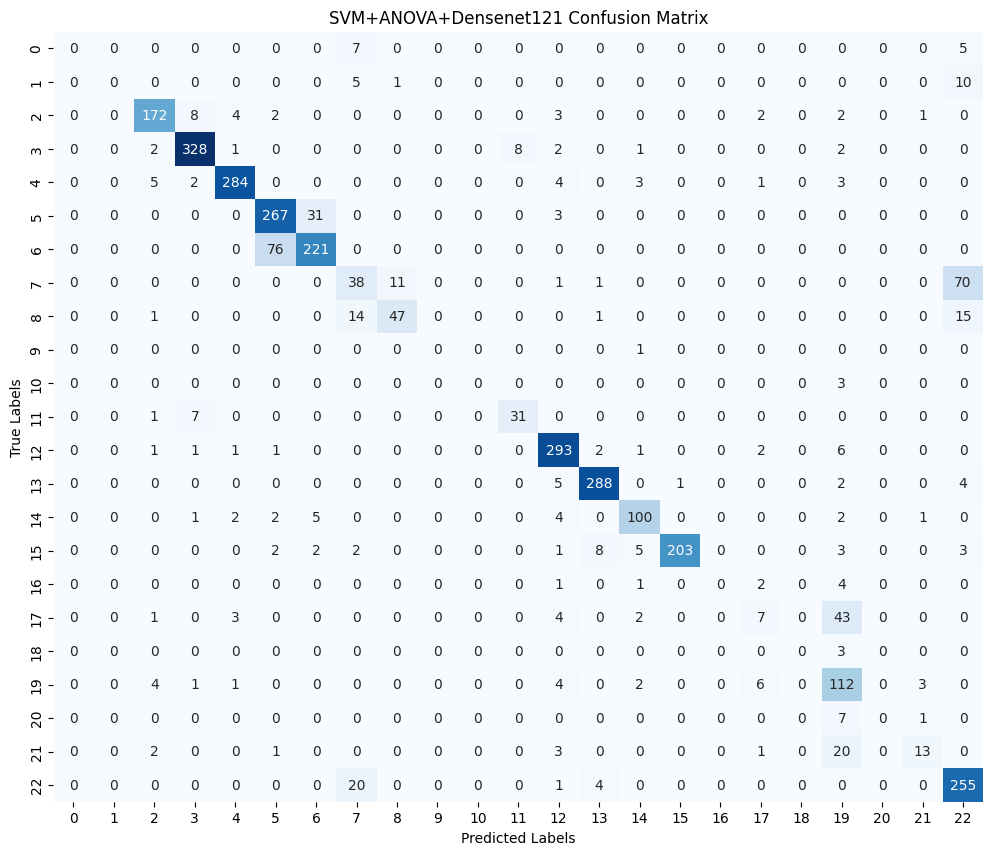

In [13]:
# Generate confusion matrices
svm_cm = confusion_matrix(y_test, y_test_pred_anova)

# Plotting confusion matrix for SVM
plt.figure(figsize=(12, 10))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("SVM+ANOVA+Densenet121 Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



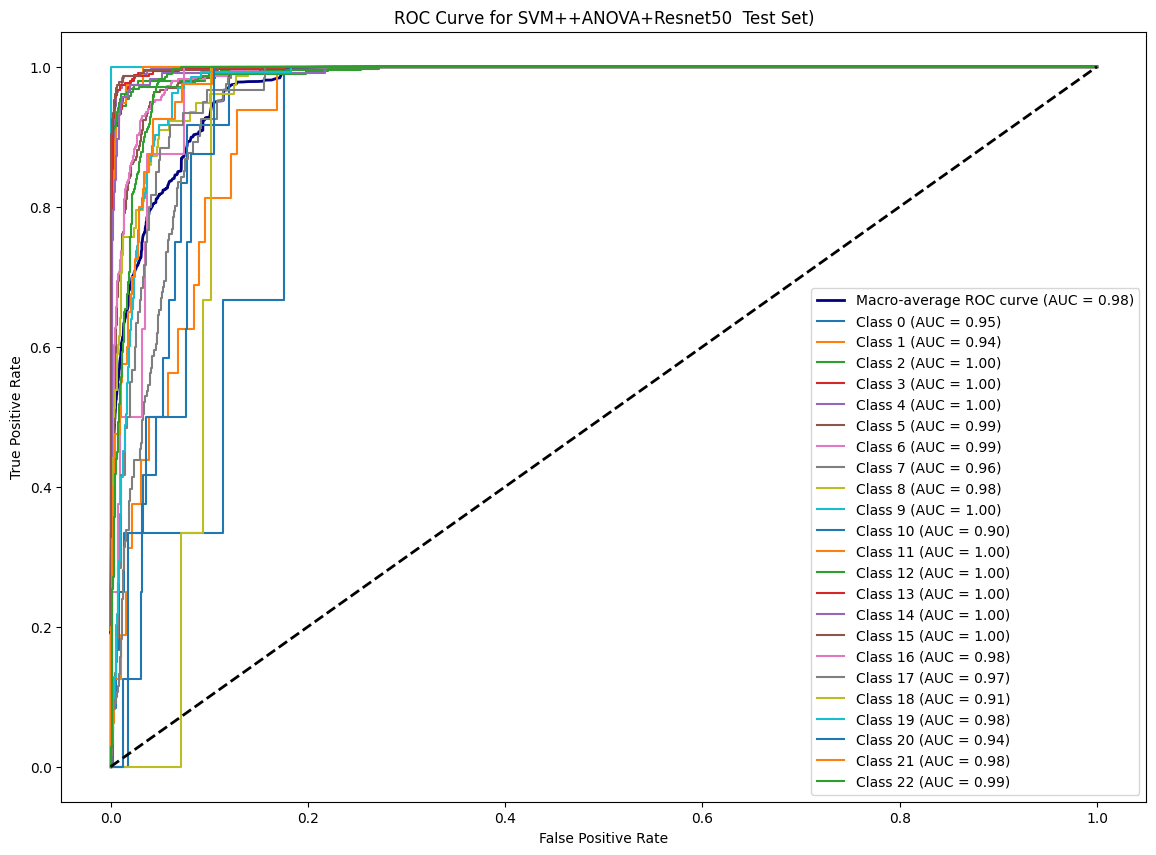

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt



# Assuming you have already loaded and preprocessed your data
y_test_bin = label_binarize(y_test, classes=np.arange(23))

# Predict probabilities for each class on test set
y_test_prob_selected = svm_classifier_anova.predict_proba(X_test_features_anova)


# Compute ROC curve and AUC for each class on test set
fpr_test_selected = dict()
tpr_test_selected = dict()
roc_auc_test_selected = dict()

for i in range(23):
    fpr_test_selected[i], tpr_test_selected[i], _ = roc_curve(y_test_bin[:, i], y_test_prob_selected[:, i])
    roc_auc_test_selected[i] = auc(fpr_test_selected[i], tpr_test_selected[i])

# Compute macro-average ROC curve and AUC for test set
all_fpr_test = np.unique(np.concatenate([fpr_test_selected[i] for i in range(23)]))
mean_tpr_test = np.zeros_like(all_fpr_test)
for i in range(23):
    mean_tpr_test += np.interp(all_fpr_test, fpr_test_selected[i], tpr_test_selected[i])
mean_tpr_test /= 23
fpr_test_selected["macro"] = all_fpr_test
tpr_test_selected["macro"] = mean_tpr_test
roc_auc_test_selected["macro"] = auc(fpr_test_selected["macro"], tpr_test_selected["macro"])

# Plot ROC curves for test set
plt.figure(figsize=(14, 10))

# Plot macro-average ROC curve
plt.plot(fpr_test_selected["macro"], tpr_test_selected["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc_test_selected["macro"]:.2f})', color='navy', linestyle='-', linewidth=2)

# Plot ROC curve for each class on test set
for i in range(23):
    plt.plot(fpr_test_selected[i], tpr_test_selected[i], label=f'Class {i} (AUC = {roc_auc_test_selected[i]:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM++ANOVA+Resnet50  Test Set)')
plt.legend(loc='lower right')
plt.show()


# **RFC**

In [18]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


# Define the number of features to select using ANOVA
num_features_to_select_anova = 1800

# Initialize the SelectKBest object with the ANOVA test
anova_selector = SelectKBest(f_classif, k=num_features_to_select_anova)

# Fit and transform the training features using ANOVA
X_train_features_anova = anova_selector.fit_transform(X_train_features, y_train)

# Transform the validation and test features based on the selected features from training
X_test_features_anova = anova_selector.transform(X_test_features)

# Print the selected feature indices based on ANOVA
selected_feature_indices_anova = anova_selector.get_support(indices=True)


# Initialize the SVM classifier
rf_classifier_anova = RandomForestClassifier(random_state=30)


# Train the SVM classifier on the features selected by ANOVA
rf_classifier_anova.fit(X_train_features_anova, y_train)

# Predictions on the validation set
y_test_pred_anova = rf_classifier_anova.predict(X_test_features_anova)

# Evaluate the performance on the validation set
accuracy_test_anova = accuracy_score(y_test, y_test_pred_anova)
classification_report_test_anova = classification_report(y_test, y_test_pred_anova)

# Print the evaluation metrics on the validation set with ANOVA selected features
print("\nValidation Accuracy (ANOVA):", accuracy_test_anova)
print("Classification Report on Test Set (ANOVA):")
print(classification_report_test_anova)



Validation Accuracy (ANOVA): 0.736380713838447
Classification Report on Test Set (ANOVA):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        16
           2       0.77      0.65      0.71       194
           3       0.79      0.94      0.86       344
           4       0.84      0.90      0.87       302
           5       0.61      0.87      0.72       301
           6       0.82      0.70      0.76       297
           7       0.36      0.17      0.23       121
           8       0.79      0.42      0.55        78
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.86      0.15      0.26        39
          12       0.63      0.93      0.76       308
          13       0.85      0.90      0.88       300
          14       0.78      0.50      0.61       117
          15       0.89      0.85      0.87 

In [19]:
# Predict using the best model
prediction_RF = rf_classifier_anova.predict(X_test_features_anova)

# Print overall accuracy
accuracy = accuracy_score(y_test, prediction_RF)
print("Accuracy =", accuracy)

# Print classification report
classification_report_result = classification_report(y_test, prediction_RF)
print("Classification Report:")
print(classification_report_result)

# Print macro and micro precision
macro_precision = precision_score(y_test, prediction_RF, average='macro')
macro_f1 = f1_score(y_test, prediction_RF, average='macro')

print("Macro Precision:", macro_precision)
print("Macro F1:", macro_f1)

Accuracy = 0.736380713838447
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        16
           2       0.77      0.65      0.71       194
           3       0.79      0.94      0.86       344
           4       0.84      0.90      0.87       302
           5       0.61      0.87      0.72       301
           6       0.82      0.70      0.76       297
           7       0.36      0.17      0.23       121
           8       0.79      0.42      0.55        78
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.86      0.15      0.26        39
          12       0.63      0.93      0.76       308
          13       0.85      0.90      0.88       300
          14       0.78      0.50      0.61       117
          15       0.89      0.85      0.87       229
          16       0.00      

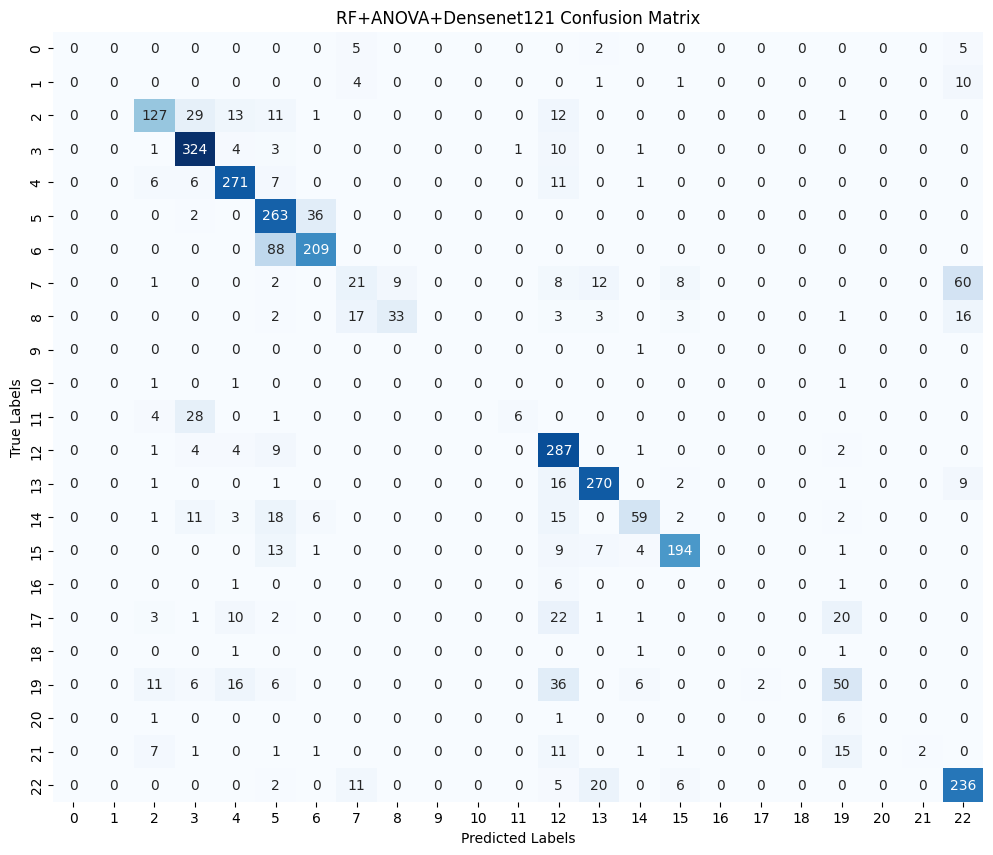

In [20]:
# Generate confusion matrices
rf_cm = confusion_matrix(y_test, prediction_RF)

# Plotting confusion matrix for SVM
plt.figure(figsize=(12, 10))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("RF+ANOVA+Densenet121 Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



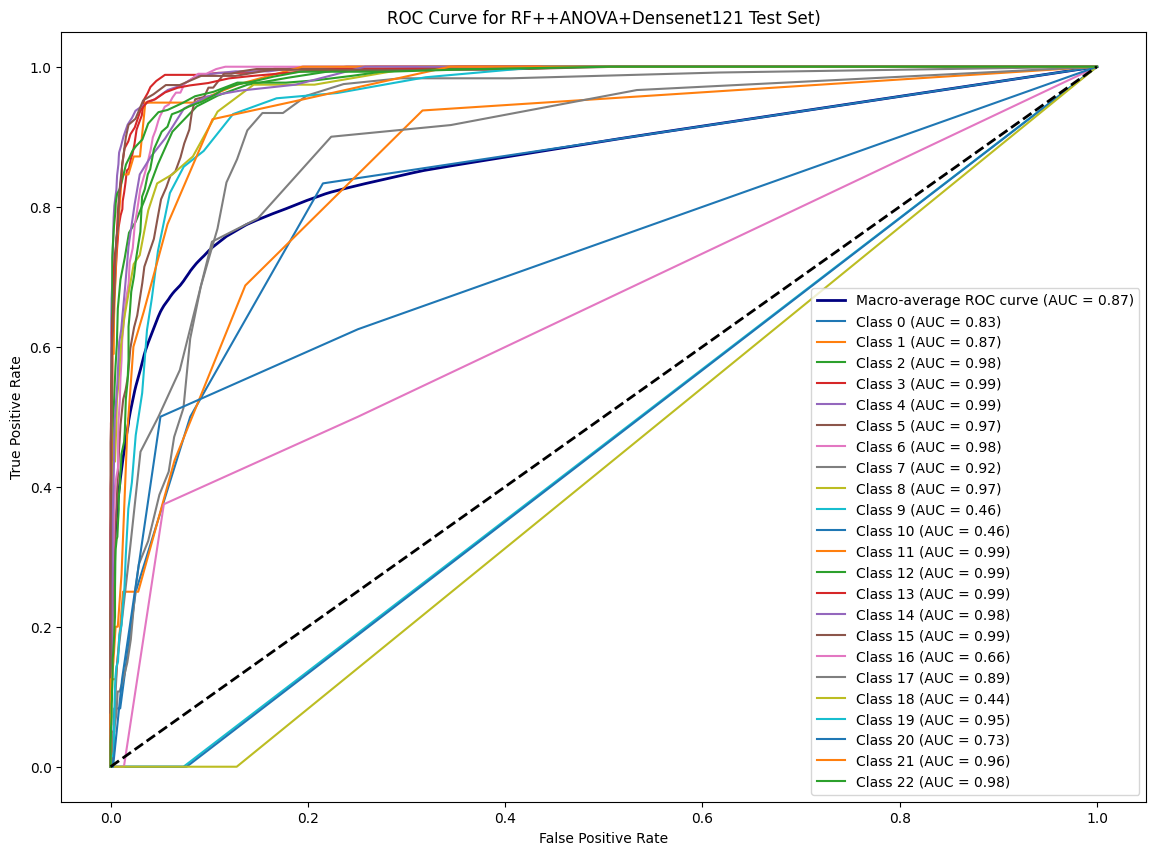

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt


# Assuming you have already loaded and preprocessed your data
y_test_bin = label_binarize(y_test, classes=np.arange(23))

# Predict probabilities for each class on test set
y_test_prob_selected = rf_classifier_anova.predict_proba(X_test_features_anova)


# Compute ROC curve and AUC for each class on test set
fpr_test_selected = dict()
tpr_test_selected = dict()
roc_auc_test_selected = dict()

for i in range(23):
    fpr_test_selected[i], tpr_test_selected[i], _ = roc_curve(y_test_bin[:, i], y_test_prob_selected[:, i])
    roc_auc_test_selected[i] = auc(fpr_test_selected[i], tpr_test_selected[i])

# Compute macro-average ROC curve and AUC for test set
all_fpr_test = np.unique(np.concatenate([fpr_test_selected[i] for i in range(23)]))
mean_tpr_test = np.zeros_like(all_fpr_test)
for i in range(23):
    mean_tpr_test += np.interp(all_fpr_test, fpr_test_selected[i], tpr_test_selected[i])
mean_tpr_test /= 23
fpr_test_selected["macro"] = all_fpr_test
tpr_test_selected["macro"] = mean_tpr_test
roc_auc_test_selected["macro"] = auc(fpr_test_selected["macro"], tpr_test_selected["macro"])

# Plot ROC curves for test set
plt.figure(figsize=(14, 10))

# Plot macro-average ROC curve
plt.plot(fpr_test_selected["macro"], tpr_test_selected["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc_test_selected["macro"]:.2f})', color='navy', linestyle='-', linewidth=2)

# Plot ROC curve for each class on test set
for i in range(23):
    plt.plot(fpr_test_selected[i], tpr_test_selected[i], label=f'Class {i} (AUC = {roc_auc_test_selected[i]:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF++ANOVA+Densenet121 Test Set)')
plt.legend(loc='lower right')
plt.show()
